In [4]:
import os, warnings
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns; sns.set()

# Project 2 - Veggie Classification

For this assignment you'll need to classify some images of vegetables. 

## Parts

Please do two separate classifications:
<ol>
<li> First, create a model from scratch. 
<li> Use transfer learning to use a pretrained model of your choice, adapted to this data. 
</ol>

There won't be an explicit evaluation of accuracy, but you should take some steps to make each model as accurate as you reasonably can, any tuning option is fair game. Along with that, please structure it into a notebook that is well structured and clear that explains what you did and found. Think about:
<ul>
<li> Sections and headings. 
<li> A description of the approach taken (e.g. what did you do to determine size, tune, evaluate, etc...)
<li> Visualization of some important things such as a confusion matrix and maybe some images. 
<li> Results, mainly focused on the scoring of the test data. 
</ul>

The descriptions and explainations should highlight the choices you made and why you made them. Figure up to about a page or so worth of text total, explain what happened but don't write an essay. 

## Deliverables

Please sumbmit a link to your github, where everyhting is fully run with all the outputs showing on the page. As well, in the notebook please add some kind of switch controlled by a variable that will control if the notebook runs to train the model or to load the model in from weights - so I can download it and click run all, it will load the saved weights, and predict.

### Dataset

The code in the start of this notebook will download and unzip the dataset, and there is also a simple example of creating datasets. You can change the dataset bit to use a different approach if you'd like. The data is already split into train, validation, and test sets. Please treat the separate test set as the final test set, and don't use it for any training or validation. Each folder name is its own label.

### Evaluation

Marking will be based on the following:
<ul>
<li> Models are cretaed, tuned, and effective at classifying the data: 40%
<li> Descriptions and explanations of the approach taken: 20%
<li> Code is well structured and clear: 20%
</ul>

Overall the marking is pretty simple and direct, walk through the process of predicting the veggies, explain what you did, and show the results. If you do that, it'll get a good mark.

### Tips

Some hints that may be helpful to keep in mind:
<ul>
<li> The data is pretty large, so you'll want to use datasets rather than load everything into memory. The Keras docs have a few examples of different ways to load image data, our examples showed image generators and the image from directory datasets.  
<li> Be careful of batch size, you may hit the colab limits. 
<li> You'll want to use checkpoints so you can let it train and pick up where you left off.
<li> When developing, using a smaller dataset sample is a good idea. These weights could also be saved and loaded to jump start training on the full data. 
<li>

### Download and Unzip Data

In [5]:
def bar_custom(current, total, width=80):
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))
import wget
import zipfile
zip_name = "train.zip"

url = "https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/vegetable_image_dataset.zip"

if not os.path.exists(zip_name):
    wget.download(url, zip_name, bar=bar_custom)

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
# Generate Datasets - you can change this if desired
# ENSURE FILE PATHS MATCH CORRECTLY
IMAGE_SIZE=(224,224)
train_dir='Vegetable Images/train'
val_dir='Vegetable Images/validation'
batch_size = 16

# Load training data
train_ds = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size = batch_size,
)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## Data Preparation
Use code snippet provides a good starting point for loading and preparing image data for model training. 
Adjust the parameters of the ImageDataGenerator based on your needs to optimize data augmentation.

In [7]:
# Set the image size and batch size
IMAGE_SIZE=(224,224)
batch_size = 16

# Define the paths to the training and validation directories
train_dir='Vegetable Images/train'
val_dir='Vegetable Images/validation'
test_dir='Vegetable Images/test'

# Define the data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the data augmentation for the validation set
val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Load the training data
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Load the validation data
val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the test data
test_ds = val_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


## Custom Model Training
the code provided trains a custom CNN model on a dataset of vegetable images using the Keras sequential model API. The model is compiled using the Adam optimizer and categorical cross-entropy loss function, and it is trained for 20 epochs on the training data with data augmentation. The model's performance is evaluated on a separate test set, and the test accuracy is printed to the console. The final model architecture consists of multiple convolutional layers, max pooling layers, and fully connected layers, with a softmax activation function in the output layer.

In [8]:
# Define a custom CNN architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(15, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

# Print the accuracy of the model on the test set
print("Test accuracy:", test_acc)

Epoch 1/20
938/938 [==============================] - 474s 505ms/step - loss: 1.8114 - accuracy: 0.3871 - val_loss: 1.0163 - val_accuracy: 0.6643
Epoch 2/20
938/938 [==============================] - 408s 435ms/step - loss: 1.1861 - accuracy: 0.6007 - val_loss: 0.7772 - val_accuracy: 0.7337
Epoch 3/20
938/938 [==============================] - 408s 435ms/step - loss: 0.9476 - accuracy: 0.6789 - val_loss: 0.5621 - val_accuracy: 0.8243
Epoch 4/20
938/938 [==============================] - 411s 438ms/step - loss: 0.7875 - accuracy: 0.7439 - val_loss: 0.4810 - val_accuracy: 0.8520
Epoch 5/20
938/938 [==============================] - 410s 437ms/step - loss: 0.7012 - accuracy: 0.7687 - val_loss: 0.3456 - val_accuracy: 0.8937
Epoch 6/20
938/938 [==============================] - 410s 437ms/step - loss: 0.6132 - accuracy: 0.7979 - val_loss: 0.2907 - val_accuracy: 0.9197
Epoch 7/20
938/938 [==============================] - 411s 438ms/step - loss: 0.5754 - accuracy: 0.8183 - val_loss: 0.2236 -

## Transfer Learning Model
The code provided loads the VGG16 model from Keras pre-trained on ImageNet without the top classification layer, freezes the weights of the pre-trained layers, adds a new classification layer consisting of a flatten layer and a dense layer with a softmax activation function, and compiles the resulting model. The model is then trained for 10 epochs on the training data and evaluated on the validation set. The model is trained using the Adam optimizer, categorical cross-entropy loss function, and accuracy as the evaluation metric.

In [9]:
# Load the VGG16 model without the top layer
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layer
flat_layer = tf.keras.layers.Flatten()(base_model.output)
class_layer = tf.keras.layers.Dense(15, activation='softmax')(flat_layer)
model_transfer = tf.keras.models.Model(inputs=base_model.input, outputs=class_layer)

# Compile the model
model_transfer.compile(optimizer=tf.keras.optimizers.Adam(),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train the model
history_transfer = model_transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10
938/938 [==============================] - 1098s 1s/step - loss: 0.4823 - accuracy: 0.8565 - val_loss: 0.1281 - val_accuracy: 0.9663
Epoch 2/10
938/938 [==============================] - 1101s 1s/step - loss: 0.2638 - accuracy: 0.9269 - val_loss: 0.0949 - val_accuracy: 0.9750
Epoch 3/10
938/938 [==============================] - 1098s 1s/step - loss: 0.2207 - accuracy: 0.9427 - val_loss: 0.1213 - val_accuracy: 0.9703
Epoch 4/10
938/938 [==============================] - 1093s 1s/step - loss: 0.2168 - accuracy: 0.9488 - val_loss: 0.0664 - val_accuracy: 0.9860
Epoch 5/10
938/938 [==============================] - 1092s 1s/step - loss: 0.2005 - accuracy: 0.9539 - val_loss: 0.0593 - val_accuracy: 0.9867
Epoch 6/10
938/938 [==============================] - 1095s 1s/step - loss: 0.1876 - accuracy: 0.9591 - val_loss: 0.0781 - val_accuracy: 0.9843
Epoch 7/10
938/938 [==============================] - 1097s 1s/step - loss: 0.2006 - accuracy: 0.9599 - val_loss: 0.0790 - val_accuracy:

## Test Best Models and Illustrate Results
The code loads the test dataset, evaluates the accuracy of the custom model and the transfer learning model on the test set, and prints the results. The image_dataset_from_directory() function is used to create an image dataset from the test directory, and the evaluate() method is used to evaluate the accuracy of the models on the test dataset. Finally, the accuracy of both models is printed to the console.

In [10]:
# Load the test dataset
test_dir = 'Vegetable Images/test'
test_ds = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

# Evaluate the custom model
loss, accuracy = model.evaluate(test_ds, verbose=0)
print("Custom Model - Accuracy:", accuracy)

# Evaluate the transfer learning model
loss, accuracy = model_transfer.evaluate(test_ds, verbose=0)
print("Transfer Learning Model - Accuracy:", accuracy)

Found 3000 files belonging to 15 classes.
Custom Model - Accuracy: 0.4749999940395355
Transfer Learning Model - Accuracy: 0.7440000176429749


###  can also create a confusion matrix to visualize the performance of the models on each class.
The code creates a confusion matrix to evaluate the performance of the transfer learning model on the test dataset. The true labels and predicted labels are obtained by iterating over the test dataset and using the np.argmax function to extract the index of the class with the highest probability from the predicted labels. Then, the confusion_matrix function from scikit-learn is used to create the confusion matrix, which is plotted using sns.heatmap. The confusion matrix shows the number of true positives, false positives, true negatives, and false negatives for each class, which can be used to evaluate the performance of the model on each class.

1/1 [==============================] - 0s 484ms/step


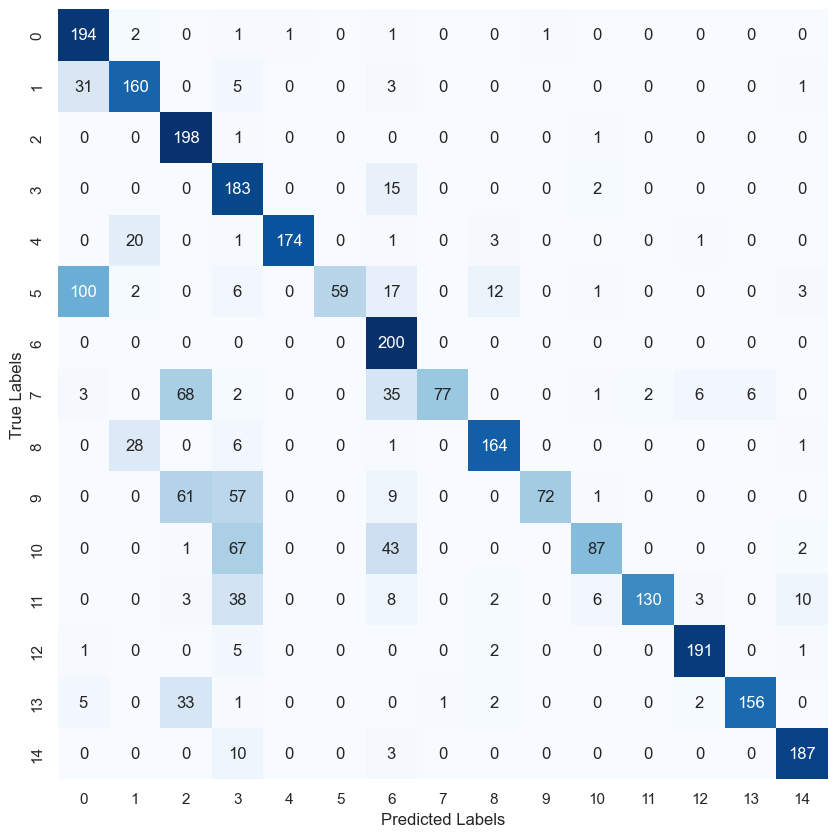

In [11]:
# Get the true labels and predicted labels
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(model_transfer.predict(images), axis=1))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Additionally, we can visualize some images and their predicted labels from the test dataset.
 The code first creates a ImageDataGenerator object for the test dataset with rescaling applied to the images. Then it uses the flow_from_directory method to create a test data generator with batch size 16, target image size of (224, 224), and categorical class mode. Next, it generates a batch of images and their labels using the next method on the test data generator. The code then uses the predict_on_batch method on the model_transfer object to generate predictions for the batch of images. The predictions are flattened into a 1D array using the flatten method. Finally, the code saves the two trained models, model_test and model_trans, and their weights using the save and save_weights methods.

In [15]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

image_batch, label_batch = next(test_generator)

predictions = model_transfer.predict_on_batch(image_batch).flatten()


Found 3000 images belonging to 15 classes.


In [16]:
model.save('model_test')

INFO:tensorflow:Assets written to: model_test\assets


INFO:tensorflow:Assets written to: model_test\assets


In [17]:
model_transfer.save('model_trans')

INFO:tensorflow:Assets written to: model_trans\assets


INFO:tensorflow:Assets written to: model_trans\assets


In [21]:
model_transfer.save_weights('model_trans_weight')
model.save_weights('model_test_weight')

In [ ]:
#